## Training

Taking the pretrained squeezenet form pytorch and finetuning on trashnet. To run this file download the dataset and put the data directory into "data_dir" variable.


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

num_classes = 3  #(classes are cardboard, glass and plastic)
batch_size = 32
num_epochs = 30
learning_rate = 0.001

# addinf transformations like resizing and cropping
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/MyDrive/project_cs667/FD-MobileNet/dataset-resized/'  # download the dataset and set the path here
image_datasets = {
    'train': datasets.ImageFolder(root=f'{data_dir}/train', transform=data_transforms['train']),
    'val': datasets.ImageFolder(root=f'{data_dir}/valid', transform=data_transforms['val'])
}

#defining the dataloaders
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True),
    'val': DataLoader(image_datasets['val'], batch_size=batch_size, shuffle=False)
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load the pretrained SqueezeNet model
model = models.squeezenet1_1(pretrained=True)

model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1))
model.num_classes = num_classes

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


#function to train the model
def train_model(model, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    print('Training complete')

train_model(model, criterion, optimizer, num_epochs=num_epochs)


Epoch 1/30
----------
train Loss: 0.9387 Acc: 0.5057
val Loss: 0.8708 Acc: 0.5494
Epoch 2/30
----------
train Loss: 0.8156 Acc: 0.6078
val Loss: 0.6667 Acc: 0.6728
Epoch 3/30
----------
train Loss: 0.6886 Acc: 0.7141
val Loss: 0.5945 Acc: 0.7160
Epoch 4/30
----------
train Loss: 0.5711 Acc: 0.7533
val Loss: 0.6702 Acc: 0.6975
Epoch 5/30
----------
train Loss: 0.6444 Acc: 0.7304
val Loss: 0.6725 Acc: 0.6420
Epoch 6/30
----------
train Loss: 0.6216 Acc: 0.7198
val Loss: 0.5049 Acc: 0.7716
Epoch 7/30
----------
train Loss: 0.5303 Acc: 0.7786
val Loss: 0.9913 Acc: 0.6728
Epoch 8/30
----------
train Loss: 0.5955 Acc: 0.7712
val Loss: 0.6072 Acc: 0.7160
Epoch 9/30
----------
train Loss: 0.4528 Acc: 0.8162
val Loss: 0.4371 Acc: 0.7778
Epoch 10/30
----------
train Loss: 0.4811 Acc: 0.7949
val Loss: 0.3710 Acc: 0.8272
Epoch 11/30
----------
train Loss: 0.4574 Acc: 0.8023
val Loss: 0.5046 Acc: 0.7716
Epoch 12/30
----------
train Loss: 0.4845 Acc: 0.7925
val Loss: 0.4766 Acc: 0.7840
Epoch 13/30
-

## Testing on the test loader

The below code tests the model on the test dataset (which is validation dataset) in this case.


In [5]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import torch
import torch.nn as nn
from tqdm import tqdm

# Define transforms for test dataset
test_transforms = {
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

test_datasets = {
    'test': datasets.ImageFolder(root=f'{data_dir}/valid', transform=test_transforms['test'])
}

test_loader = {
    'test': DataLoader(test_datasets['test'], batch_size=batch_size, shuffle=False)
}


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model.eval()

correct = 0
total = 0
criterion = nn.CrossEntropyLoss()
test_loss = 0.0

with torch.no_grad():
    for inputs, labels in tqdm(test_loader['test'], desc="Testing"):
        inputs, labels = inputs.to(device), labels.to(device)  # Move to device

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        test_loss += loss.item() * inputs.size(0)

        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_loss = test_loss / total
test_accuracy = correct / total * 100

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")


Testing: 100%|██████████| 6/6 [00:01<00:00,  4.79it/s]

Test Loss: 0.2912
Test Accuracy: 87.65%


## Generating the confusion matrix

The below code generates the confusion matrix.

{'test': <torch.utils.data.dataloader.DataLoader object at 0x7b309035cf10>}


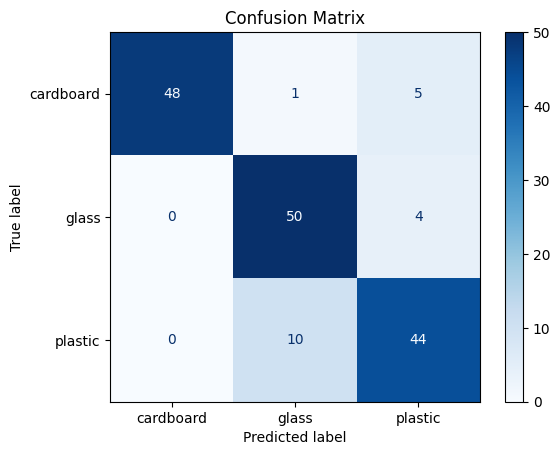

Confusion Matrix:
 [[48  1  5]
 [ 0 50  4]
 [ 0 10 44]]


In [ ]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model.eval()

all_preds = []
all_labels = []

print(test_loader)
with torch.no_grad():
    for inputs, labels in test_loader['test']:  
        inputs, labels = inputs.to(device), labels.to(device)  
        outputs = model(inputs)  
        _, preds = torch.max(outputs, 1)  # 
        all_preds.extend(preds.cpu().numpy())  
        all_labels.extend(labels.cpu().numpy())  

cm = confusion_matrix(all_labels, all_preds)

class_labels = ['cardboard', 'glass', 'plastic']  

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

print("Confusion Matrix:\n", cm)
